# Exercise 2

## Physics 7810
## Due March 16, 2020

## E2.1 - Neighbor lists and cell lists

In this exercise you will implement the *neighbor list* and *cell list* methods for speeding up force/energy calculations in an MD simulation of the two-dimensional (2D) Weeks-Chandler-Andersen (WCA) model with periodic boundary conditions, and will compare the performance of these algorithms with an all-pairs ($O(N^2)$) neighbor search.

Recall that the WCA potential is just the Lennard-Jones potential truncated at the minimum ($r_c = 2^{1/6} \sigma$) and shifted so that the potential is continuous at the cutoff distance. In the WCA model, no long-range corrections to the potential energy or pressure (or other thermodynamic properties) are included.

(1) Write an MD simulation program for the 2D WCA model in a square box with periodic boundary conditions, using the velocity Verlet algorithm, and using an all-pairs search to compute pair interactions. Verify that the program works correctly, with stable dynamics (e.g., good energy conservation). Compare the average potential energy per particle and pressure measured in your simulation with the data in the file `WCA_thermodynamics_T_0.6.pdf` (from my PhD thesis!) in the Modules/Exercises folder in Canvas, which was obtained at a reduced temperature of $T^\ast = 0.6$. Try to reproduce the data on the low-density side of the melting transition ($\rho^\ast < 0.85$). To do this it's helpful to have a way to adjust the temperature of the system (e.g., a *thermostat*). I'd recommend using one of the simplest methods, involving periodic resampling of particle velocities (the *Andersen thermostat*), which is described in Section 3.8.1 in Allen & Tildesley.

(2) Implement the Verlet neighbor list method, with the neighbor list skin $\delta = r_l - r_c$ as an additional parameter that can be varied to optimize the performance of the algorithm. Note that the neighbor list cutoff $r_l$ cannot exceed half the linear dimension of the simulation box (i.e., you should make sure that $r_l \leq L/2$). The neighbor list for each particle can be implemented either as a simple array or as a linked list.

* Verify that using neighbor lists gives identical results to the all-pairs neighbor search, given the same initial conditions, at least for several hundred timesteps. If you see a significant discrepancy, this probably means that there's a mistake in your neighbor list implementation. Use the method discussed in class and in Allen & Tildesley (Section 5.3.1) to determine when to update the neighbor list.

* Measure the speedup of the neighbor list method relative to the all pairs method for various values of $\delta$ and $N$ (the number of particles). Hint: take a look at the `time` and `timeit` Python modules.

(3) Implement the cell search method, and repeat the steps outlined above for the neighbor list method. I'd recommend implementing the cell method using double-connected linked lists, as discussed in class and in Allen & Tildesley (Section 5.3.2). To acheive the best performance, you'll need to define `head` and `tail` arrays that contain the labels of the first and last particles in the linked list for each cell, `prev` and `next` arrays that contain the labels of the previous and next particles in the linked list that a given particle belongs to, and a `cell` array that specifies which cell a given particle is assigned to. Some care needs to be taken in handling periodic boundary conditions when using cell lists to calculate energies and forces.

### Solution

#### Problem 1: Application of Andersen thermostat with all-pairs search method

First, we import the package for MD simulations.

In [1]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [34]:
param = Initialization('Exercise_02.yml')
MD = MolecularDynamics(param)

In [35]:
%%prun -s cumulative -q -l 10 -T prun0
t1 = time.time()
MD.search_method = 'all-pairs'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))
print(MD.search_method)
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print(TA.temp[-1])

Elapsed time: 68.92207050323486
all-pairs
2.0525924152923274
 
*** Profile printout saved to text file 'prun0'. 


In [36]:
print(open('prun0', 'r').read())

         63890218 function calls (63888760 primitive calls) in 68.929 seconds

   Ordered by: cumulative time
   List reduced from 140 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   68.929   68.929 {built-in method builtins.exec}
        1    0.000    0.000   68.929   68.929 <string>:2(<module>)
        1    0.077    0.077   68.923   68.923 Molecular_Simulations.py:726(verlet_integration)
     1600    7.077    0.004   68.125    0.043 Molecular_Simulations.py:316(total_force)
  3920000    6.684    0.000   60.884    0.000 Molecular_Simulations.py:295(LJ_force_ij)
  3920000   16.304    0.000   50.324    0.000 Molecular_Simulations.py:249(calc_dist)
  3920801   12.127    0.000   22.908    0.000 linalg.py:2293(norm)
  4136265    1.565    0.000   11.736    0.000 fromnumeric.py:3373(round_)
  4136265    2.275    0.000   10.171    0.000 fromnumeric.py:2940(around)
  4136265    1.897    0.000    7.896    0.000

In [37]:
%%prun -s cumulative -q -l 10 -T prun1
t1 = time.time()
MD.search_method = 'verlet'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))
print(MD.search_method)
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print(TA.temp[-1])

Elapsed time: 57.0455641746521
verlet
2.0525924152923274
 
*** Profile printout saved to text file 'prun1'. 


In [38]:
print(open('prun1', 'r').read())

         50137777 function calls (50136319 primitive calls) in 57.052 seconds

   Ordered by: cumulative time
   List reduced from 146 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   57.052   57.052 {built-in method builtins.exec}
        1    0.000    0.000   57.052   57.052 <string>:2(<module>)
        1    0.090    0.090   57.045   57.045 Molecular_Simulations.py:726(verlet_integration)
  3143263   13.979    0.000   42.801    0.000 Molecular_Simulations.py:249(calc_dist)
     1600    4.417    0.003   41.945    0.026 Molecular_Simulations.py:316(total_force)
  2153463    5.113    0.000   37.362    0.000 Molecular_Simulations.py:295(LJ_force_ij)
  3184064   10.557    0.000   19.716    0.000 linalg.py:2293(norm)
      808    1.148    0.001   14.283    0.018 Molecular_Simulations.py:558(verlet_list)
  3359528    1.358    0.000    9.992    0.000 fromnumeric.py:3373(round_)
  3359528    1.937    0.000    

0.5981269904261994

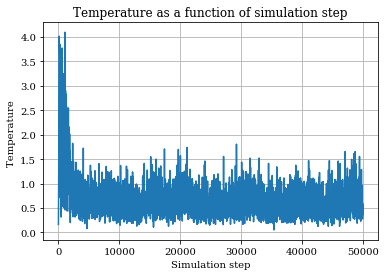

In [12]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
TA.plot_2d(TA.temp, 'Temperature')
TA.calculate_RMSF(TA.temp)

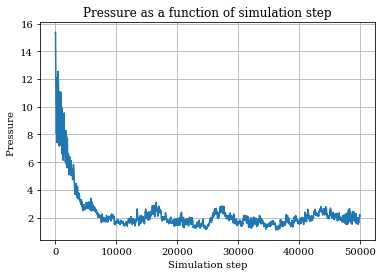

In [13]:
TA.plot_2d(TA.pressure, 'Pressure')

In [17]:
len(TA.pressure)

5001

In [19]:
np.mean(TA.pressure[4000:])

2.071241680753028

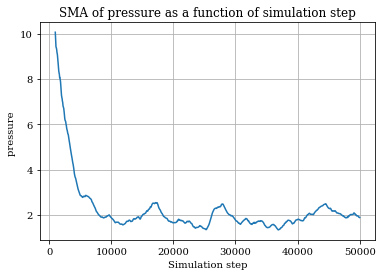

In [14]:
SMA = TA.plot_SMA(100, TA.pressure, 'pressure')

#### Problem 2: Implementation of neighbor lists

In [1]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [2]:
%%prun -s cumulative -q -l 10 -T prun0
t1 = time.time()
param = Initialization('Exercise_02.yml')
MD = MolecularDynamics(param)
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Elapsed time: 0.7250959873199463
 
*** Profile printout saved to text file 'prun0'. 


In [2]:
print(open('prun0', 'r').read())

         48048 function calls (47625 primitive calls) in 0.084 seconds

   Ordered by: cumulative time
   List reduced from 245 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.084    0.084 {built-in method builtins.exec}
        1    0.000    0.000    0.084    0.084 <string>:2(<module>)
        1    0.000    0.000    0.053    0.053 Molecular_Simulations.py:693(verlet_integration)
        1    0.000    0.000    0.040    0.040 Molecular_Simulations.py:786(output_data)
        1    0.011    0.011    0.040    0.040 Molecular_Simulations.py:390(virial)
        1    0.000    0.000    0.031    0.031 Molecular_Simulations.py:42(__init__)
     1560    0.009    0.000    0.027    0.000 Molecular_Simulations.py:244(calc_dist)
      780    0.003    0.000    0.022    0.000 Molecular_Simulations.py:290(LJ_force_ij)
        1    0.000    0.000    0.016    0.016 __init__.py:65(load)
        1    0.000    0.000    0.

#### Questinos to ask
- The mixing of Newtonian dynamics with stochastic collisions turns the Molecular Dynamics simulation into a Markov process. blablabla
- Draw from maxwell-Boltzmann: not rigorous enough?

In [5]:
A = MD.coords
B = MD.coords + 1

In [25]:
A

array([[-1.24404061,  1.08650181],
       [ 0.85392235, -0.37264796],
       [ 1.05170761,  0.18589252],
       ...,
       [-0.4253722 ,  0.46688536],
       [ 1.19515935,  1.02695679],
       [-0.76023485, -1.27546294]])

In [19]:
a = [C[i][0] ** 2 + C[i][1] ** 2 for i in range(len(C))]

In [28]:
t1 = time.time()
for i in range(10000):
    a = [norm(A[i]-B[i]) for i in range(len(C))]
t2 = time.time()
t2 - t1

33.216803312301636

In [30]:
t1 = time.time()
C = B - A
for i in range(10000):
    a = [norm(C[i]) for i in range(len(C))]
t2 = time.time()
t2 - t1

28.496031999588013

In [31]:
a

[1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4